In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported")

Libraries imported


In [23]:
import gradio as gr
import pickle
from tensorflow.keras.models import load_model

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the model
model = load_model('fake_news_lstm_model.h5')

print("Gradio, tokenizer and model loaded successfully!")

Gradio, tokenizer and model loaded successfully!


In [ ]:
# Load datasets
true_path = 'true.csv'
df_true = pd.read_csv(true_path)

print("true.csv shape:", df_true.shape)

true.csv shape: (21417, 4)


In [ ]:
from google.colab import files

print("Please upload 'fake.csv'")
uploaded = files.upload()

for filename in uploaded.keys():
  print(f'Uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Please upload 'fake.csv'


Saving fake.csv to fake.csv
Uploaded file "fake.csv" with length 62789876 bytes


In [ ]:
fake_path = 'fake.csv'
df_fake = pd.read_csv(fake_path)

print("fake.csv shape:", df_fake.shape)

fake.csv shape: (23481, 4)


In [ ]:
df_true = df_true.copy()
df_fake = df_fake.copy()

df_true['label'] = 0
df_fake['label'] = 1

# Ensure 'text' column exists; if not, try to construct text from available columns
for df,name in [(df_true,'true'),(df_fake,'fake')]:
    if 'text' not in df.columns:
        # try 'content' or 'article' or 'title'
        for col in ['content','article','body','title']:
            if col in df.columns:
                df['text'] = df[col]
                break
    # If still missing, create empty strings
    if 'text' not in df.columns:
        df['text'] = ''

# Concatenate
df = pd.concat([df_true, df_fake], ignore_index=True)
print("Combined shape:", df.shape)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


df.head()

Combined shape: (44898, 5)


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


Label distribution:
 label
1    23481
0    21417
Name: count, dtype: int64

Text length (words) stats:
count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text_len, dtype: float64


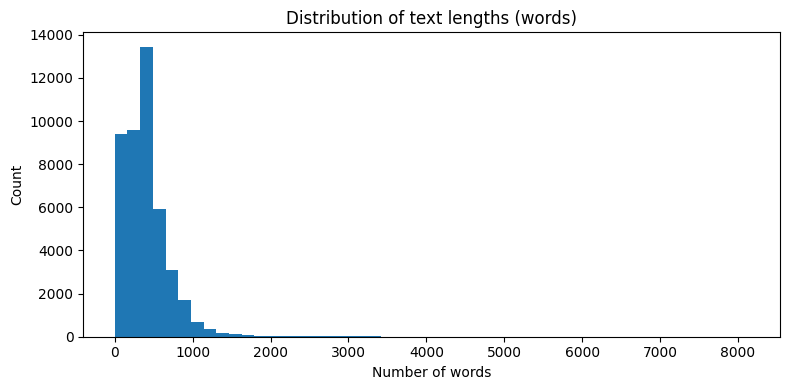

In [ ]:
# Basic EDA
print("Label distribution:\n", df['label'].value_counts())

# Text length distribution
df['text_len'] = df['text'].astype(str).apply(lambda x: len(x.split()))
print("\nText length (words) stats:")
print(df['text_len'].describe())

plt.figure(figsize=(8,4))
plt.hist(df['text_len'], bins=50)
plt.title('Distribution of text lengths (words)')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

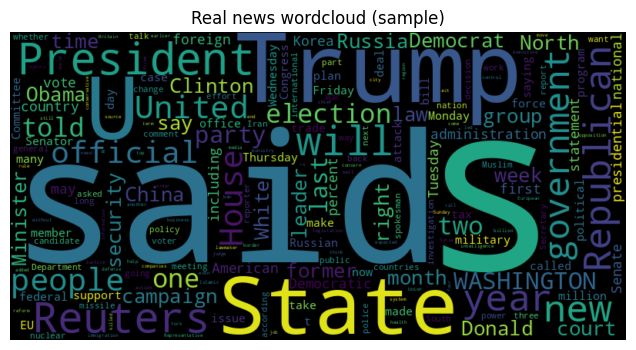

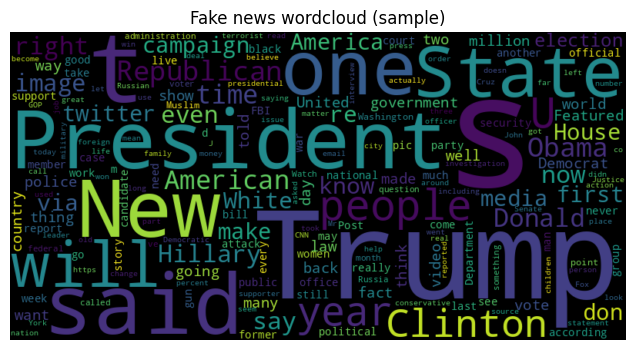

In [ ]:

def generate_wordcloud(text_series, title):
    text = ' '.join(text_series.astype(str).dropna().values)
    wordcloud = WordCloud(width=800, height=400, collocations=False).generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(df[df['label']==0]['text'].sample(1000, random_state=1), 'Real news wordcloud (sample)')
generate_wordcloud(df[df['label']==1]['text'].sample(1000, random_state=1), 'Fake news wordcloud (sample)')

In [ ]:

import string
def clean_text(text):
    text = str(text)
    # lower
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # remove punctuation & digits
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['text_clean'] = df['text'].apply(clean_text)
df['text_clean'].head()

,text_clean
0,donald trump s white house is in chaos and the...
1,now that donald trump is the presumptive gop n...
2,mike pence is a huge homophobe he supports exg...
3,san francisco reuters california attorney gene...
4,twisted reasoning is all that comes from pelos...


In [ ]:
# Tokenization and padding
MAX_VOCAB = 30000
MAX_LEN = 300  # max sequence length (in words)

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_clean'])

sequences = tokenizer.texts_to_sequences(df['text_clean'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("Padded shape:", padded.shape)

# Prepare labels
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Padded shape: (44898, 300)
Train shape: (35918, 300) Test shape: (8980, 300)


In [ ]:
# Build an LSTM model
EMBEDDING_DIM = 128

def build_lstm(vocab_size=MAX_VOCAB, embedding_dim=EMBEDDING_DIM, input_length=MAX_LEN):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_lstm()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
EPOCHS = 3
BATCH_SIZE = 64

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1
)

Epoch 1/3
506/506 ━━━━━━━━━━━━━━━━━━━━ 232s 454ms/step - accuracy: 0.6648 - loss: 0.5999 - val_accuracy: 0.7597 - val_loss: 0.5172
Epoch 2/3
506/506 ━━━━━━━━━━━━━━━━━━━━ 234s 463ms/step - accuracy: 0.7792 - loss: 0.4806 - val_accuracy: 0.6826 - val_loss: 0.5752
Epoch 3/3
506/506 ━━━━━━━━━━━━━━━━━━━━ 229s 453ms/step - accuracy: 0.7991 - loss: 0.3990 - val_accuracy: 0.9452 - val_loss: 0.1579


In [ ]:
# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

# Predictions & report
y_pred_proba = model.predict(X_test, batch_size=128)
y_pred = (y_pred_proba > 0.5).astype(int).reshape(-1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

281/281 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.9422 - loss: 0.1638
Test loss: 0.1602, Test accuracy: 0.9447
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step

Classification report:
              precision    recall  f1-score   support

           0     0.9254    0.9615    0.9431      4284
           1     0.9636    0.9293    0.9461      4696

    accuracy                         0.9447      8980
   macro avg     0.9445    0.9454    0.9446      8980
weighted avg     0.9454    0.9447    0.9447      8980

Confusion matrix:
 [[4119  165]
 [ 332 4364]]


In [ ]:
# Save tokenizer and model
import pickle
# Change the paths to save in the current working directory or a custom folder within it
tokenizer_path = 'tokenizer.pickle'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_path = 'fake_news_lstm_model.h5'
model.save(model_path)
print("Saved tokenizer to:", tokenizer_path)
print("Saved model to:", model_path)

Saved tokenizer to: tokenizer.pickle
Saved model to: fake_news_lstm_model.h5


In [ ]:
# Define the prediction function
def predict_news(text):
    # Clean the input text using the previously defined clean_text function
    cleaned_text = clean_text(text)

    # Tokenize the cleaned text
    sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

    # Make prediction
    prediction = model.predict(padded_sequence)

    # Return the prediction result
    if prediction[0][0] > 0.5:
        return "Fake News (Score: {:.2f})".format(prediction[0][0])
    else:
        return "Real News (Score: {:.2f})".format(1 - prediction[0][0])

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(lines=5, placeholder="Enter news text here..."),
    outputs="text",
    title="Fake News Detector",
    description="Enter a news article to predict if it's real or fake."
)

# Launch the interface
iface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1776db52864a2f300e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Using existing dataset file at: .gradio/flagged/dataset1.csv


281/281 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step


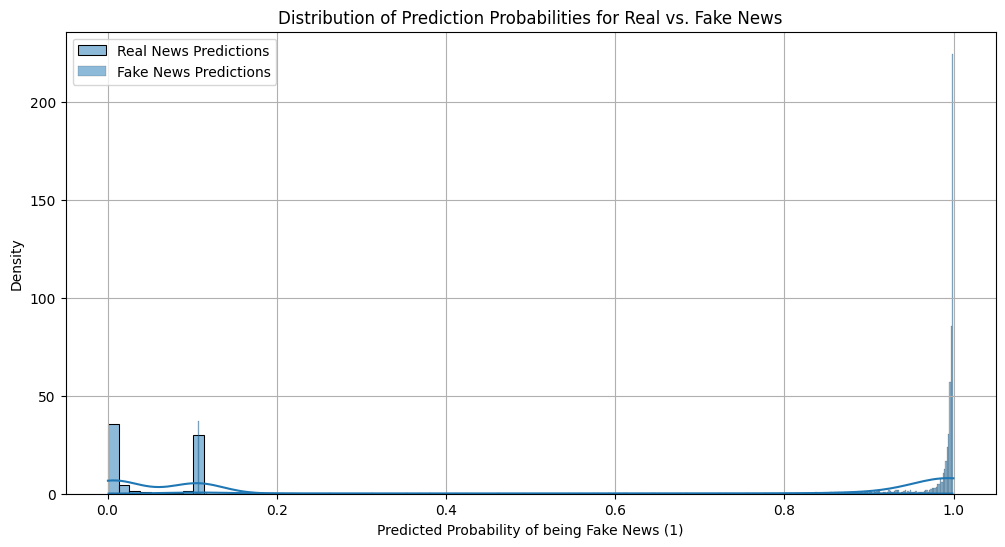

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
y_pred_proba = model.predict(X_test)

# Separate probabilities for true and fake news
proba_real = y_pred_proba[y_test == 0]
proba_fake = y_pred_proba[y_test == 1]

plt.figure(figsize=(12, 6))

sns.histplot(proba_real, color='blue', label='Real News Predictions', kde=True, stat='density', alpha=0.5)
sns.histplot(proba_fake, color='red', label='Fake News Predictions', kde=True, stat='density', alpha=0.5)

plt.title('Distribution of Prediction Probabilities for Real vs. Fake News')
plt.xlabel('Predicted Probability of being Fake News (1)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
